In [2]:
import numpy as np
#import jax.numpy as jnp

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *

In [178]:
def load(sim_name, 
         x_slice,
         y_slice,
         data_time_start=-3, 
         data_time_len=2,
         data_time_step=1,
         verbose=False
        ):
    data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim_name}/{sim_name}.npy")
    with open(data_path, 'rb') as f:
        data = np.load(f)

    data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim_name}/simulation.txt")
    with open(data_path, 'r') as f:
        simulation = eval(f.read())
        
    t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)
    
    if verbose:
        print(f"Initial dataset shape was: {data.shape}.")
    
    L = simulation.L[0]
    x_size = data.shape[1]
    y_size = data.shape[2]
    N = x_size*y_size    
    dxdy = x_size*y_size/L**2
    
       
    if data_time_start+data_time_len+1 < 0:
        time_slice=slice(data_time_start, data_time_start+data_time_len+1, data_time_step)
    else:
        time_slice=slice(data_time_start, data.shape[3], data_time_step)
    data_time_slice=slice(data_time_start, data_time_start+data_time_len, data_time_step)
    
    data_time = data[:, :, :, time_slice].copy()
    data = data[:, :, :, data_time_slice] 
    
    if verbose:
        print(f"It reduced to: {data.shape}.")
    
    t_star_time = t_star[time_slice].copy()
    t_star = t_star[data_time_slice]
    
    assert len(t_star) > 1, f"There must be at least two time steps. There are '{len(t_star)}'."
    
    c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_xx = np.einsum("ctij -> cijt", c_xx)
    c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_yy = np.einsum("ctij -> cijt", c_yy)

    c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_t = np.einsum("ctij -> cijt", c_t)
    
    diff_Y = np.array([[dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    diff_Y = np.einsum("ctij -> cijt", diff_Y)
        
    if verbose:
        print(f"And its X-Y size reduced to: {data[:, x_slice, y_slice, :].shape}.")
        
    return (simulation, t_star,
            (data[:, x_slice, y_slice, :], 
             c_xx[:, x_slice, y_slice, :], 
             c_yy[:, x_slice, y_slice, :], 
             c_t[:, x_slice, y_slice, :]),
            (data, c_xx, c_yy, c_t))
        



In [433]:
import jax.numpy as jnp


def L2_mean(x):
    return jnp.mean(x**2)

def root_L2_mean(x):
    return jnp.sqrt(L2_mean(x))

def create_u_residual(c, c_xx, c_yy, c_t):
    u = c[0, ...]
    v = c[1, ...]
    u_xx = c_xx[0, ...]
    u_yy = c_yy[0, ...]
    u_t = c_t[0, ...]
    
    def res_u(D_u, kappa_u, rho_u, mu_u, sigma_u):
        f = u * u * v / (1.0 + kappa_u * u * u)    
        return D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    return res_u

def create_v_residual(c, c_xx, c_yy, c_t):
    u = c[0, ...]
    v = c[1, ...]
    v_xx = c_xx[1, ...]
    v_yy = c_yy[1, ...]
    v_t = c_t[1, ...]    
    
    def res_v(D_v, kappa_u, rho_v, sigma_v):
        f = u * u * v / (1.0 + kappa_u * u * u)    
        return D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    
    return res_v

def create_loss_u(c, c_xx, c_yy, c_t):
    res_u = create_u_residual(c, c_xx, c_yy, c_t)
    def loss_u(D_u, kappa_u, rho_u, mu_u, sigma_u):
        return res_u(D_u, kappa_u, rho_u, mu_u, sigma_u)
    
    return loss_u

def create_loss_v(c, c_xx, c_yy, c_t):
    res_v = create_v_residual(c, c_xx, c_yy, c_t)
    def loss_v(D_v, kappa_u, rho_v, sigma_v):
        return res_v(D_v, kappa_u, rho_v, sigma_v)
    
    return loss_v

def create_loss(c, c_xx, c_yy, c_t):
    res_u = create_u_residual(c, c_xx, c_yy, c_t)
    res_v = create_v_residual(c, c_xx, c_yy, c_t)
    def loss(D_u, D_v, kappa_u, rho_u, mu_u, sigma_u, rho_v, sigma_v):
        return res_u(D_u, kappa_u, rho_u, mu_u, sigma_u) + res_v(D_v, kappa_u, rho_v, sigma_v)
    
    return loss

def create_l2_loss(c, c_xx, c_yy, c_t):    
    l = create_loss(c, c_xx, c_yy, c_t)
    def l2_loss(D_u, D_v, kappa_u, rho_u, mu_u, sigma_u, rho_v, sigma_v):
        return L2_mean(l(D_u, D_v, kappa_u, rho_u, mu_u, sigma_u, rho_v, sigma_v))
    
    return l2_loss

def residuals(c, c_xx, c_yy, c_t, simulation):
     
    u = c[0, ...]
    v = c[1, ...]
    u_xx = c_xx[0, ...]
    u_yy = c_yy[0, ...]
    u_t = c_t[0, ...]
    v_xx = c_xx[1, ...]
    v_yy = c_yy[1, ...]
    v_t = c_t[1, ...]    
    
    D_u = simulation.Ds[0] 
    D_v = simulation.Ds[1]
    kappa_u = simulation.parameters['kappa_u']
    rho_u = simulation.parameters['rho_u']
    mu_u = simulation.parameters['mu_u']
    sigma_u = simulation.parameters['sigma_u']
    rho_v = simulation.parameters['rho_v']
    sigma_v = simulation.parameters['sigma_v']
    
    f = u * u * v / (1.0 + kappa_u * u * u)
    
    res_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    res_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    return (res_u, res_v)



In [434]:
simulation_name = "Koch_Meinhardt_2"
simulation, t_star, (c, c_xx, c_yy, c_t), _ = load(simulation_name, 
                                                   x_slice=slice(30,65,5),
                                                   y_slice=slice(50,85,5),
                                                   data_time_start=-3, 
                                                   data_time_len=2,
                                                   data_time_step=1,
                                                   verbose=True)

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size    
dxdy = x_size*y_size/L**2

Initial dataset shape was: (2, 100, 100, 513).
It reduced to: (2, 100, 100, 2).
And its X-Y size reduced to: (2, 7, 7, 2).


In [435]:


loss = create_loss(jnp.asarray(c),
                   jnp.asarray(c_xx),
                   jnp.asarray(c_yy),
                   jnp.asarray(c_t))

l2_loss =create_l2_loss(jnp.asarray(c),
                   jnp.asarray(c_xx),
                   jnp.asarray(c_yy),
                   jnp.asarray(c_t))

loss_u = create_loss_u(jnp.asarray(c),
                       jnp.asarray(c_xx),
                       jnp.asarray(c_yy),
                       jnp.asarray(c_t))
loss_v = create_loss_v(jnp.asarray(c),
                       jnp.asarray(c_xx),
                       jnp.asarray(c_yy),
                       jnp.asarray(c_t))


In [437]:
l2_loss(1,1,1,1,1,1,1,1)

Array(35.118717, dtype=float32)

In [438]:
def create_range(centre, delta=None, steps=20, scale=.2):
    if delta is None:
        if centre != 0:
            delta = centre*scale
        else:
            delta = 1.0
    return np.linspace(centre-delta, centre+delta, steps+1)

D_u_r = create_range(simulation.Ds[0])
D_v_r = create_range(simulation.Ds[1])
kappa_u_r = create_range(simulation.parameters['kappa_u'])
rho_u_r = create_range(simulation.parameters['rho_u'])
rho_v_r = create_range(simulation.parameters['rho_v'])
sigma_u_r = create_range(simulation.parameters['sigma_u'], scale=.1)
sigma_v_r = create_range(simulation.parameters['sigma_v'], scale=.1)
mu_u_r = create_range(simulation.parameters['mu_u'])


In [439]:
from itertools import combinations

def curry_func(f, param1_name, param2_name, param_others):
    def f_cuury(param1, param2):
        params = {
            **param_others,
            **{param1_name:param1,
               param2_name:param2}
        }
        return f(**params)
    return f_cuury

params = {"D_u": simulation.Ds[0],
          "D_v": simulation.Ds[1],
          "kappa_u": simulation.parameters["kappa_u"],
          "rho_u": simulation.parameters["rho_u"],
          "mu_u": simulation.parameters["mu_u"],
          "sigma_u": simulation.parameters["sigma_u"],
          "rho_v": simulation.parameters["rho_v"],
          "sigma_v": simulation.parameters["sigma_v"]}

u_params = {k: params[k] for k in ("D_u", "kappa_u", "rho_u", "mu_u", "sigma_u")}
u_arrays = {"D_u": D_u_r,
            "kappa_u": kappa_u_r,
            "rho_u": rho_u_r,
            "mu_u": mu_u_r,
            "sigma_u": sigma_u_r}

v_params = {k: params[k] for k in ("D_v", "kappa_u", "rho_v", "sigma_v")}
v_arrays = {"D_v": D_v_r,
            "kappa_u": kappa_u_r,
            "rho_v": rho_v_r,
            "sigma_v": sigma_v_r}

u_curry_func_others_combinations = [(param1, u_arrays[param1],
                                     param2, u_arrays[param2], { k:v for k, v in u_params.items()
        if k != param1 and k != param2
     })
    for param1, param2 in combinations(u_params.keys(), 2)
]

v_curry_func_others_combinations = [(param1, v_arrays[param1],
                                     param2, v_arrays[param2], { k:v for k, v in v_params.items()
        if k != param1 and k != param2
     })
    for param1, param2 in combinations(v_params.keys(), 2)
]

loss_u_combinations = [ curry_func(loss_u, param1, param2, others) 
                       for param1,_ ,param2,_, others in u_curry_func_others_combinations]
loss_v_combinations = [ curry_func(loss_v, param1, param2, others) 
                       for param1,_, param2,_, others in v_curry_func_others_combinations]

In [440]:
def res_2D(f, params1, params2, ret):    
    for i, param1 in enumerate(params1):
        for j, param2 in enumerate(params2):
            ret[i, j] =  L2_mean(f(param1, param2))
    return ret

u_losses = [res_2D(func, arr1, arr2, np.zeros((arr1.shape[0], arr2.shape[0]))) 
            for func, (_, arr1, _, arr2, _) in zip(loss_u_combinations,u_curry_func_others_combinations)]

v_losses = [res_2D(func, arr1, arr2, np.zeros((arr1.shape[0], arr2.shape[0]))) 
            for func, (_, arr1, _, arr2, _) in zip(loss_v_combinations,v_curry_func_others_combinations)]

In [441]:
symbols = {"D_u": "D_u", "D_v": "D_v", "kappa_u": r"\kappa_u", 
            "rho_u":r"\rho_u", "rho_v":r"\rho_v", "mu_u":r"\mu_u",
            "sigma_u":r"\sigma_u", "sigma_v":r"\sigma_v"}

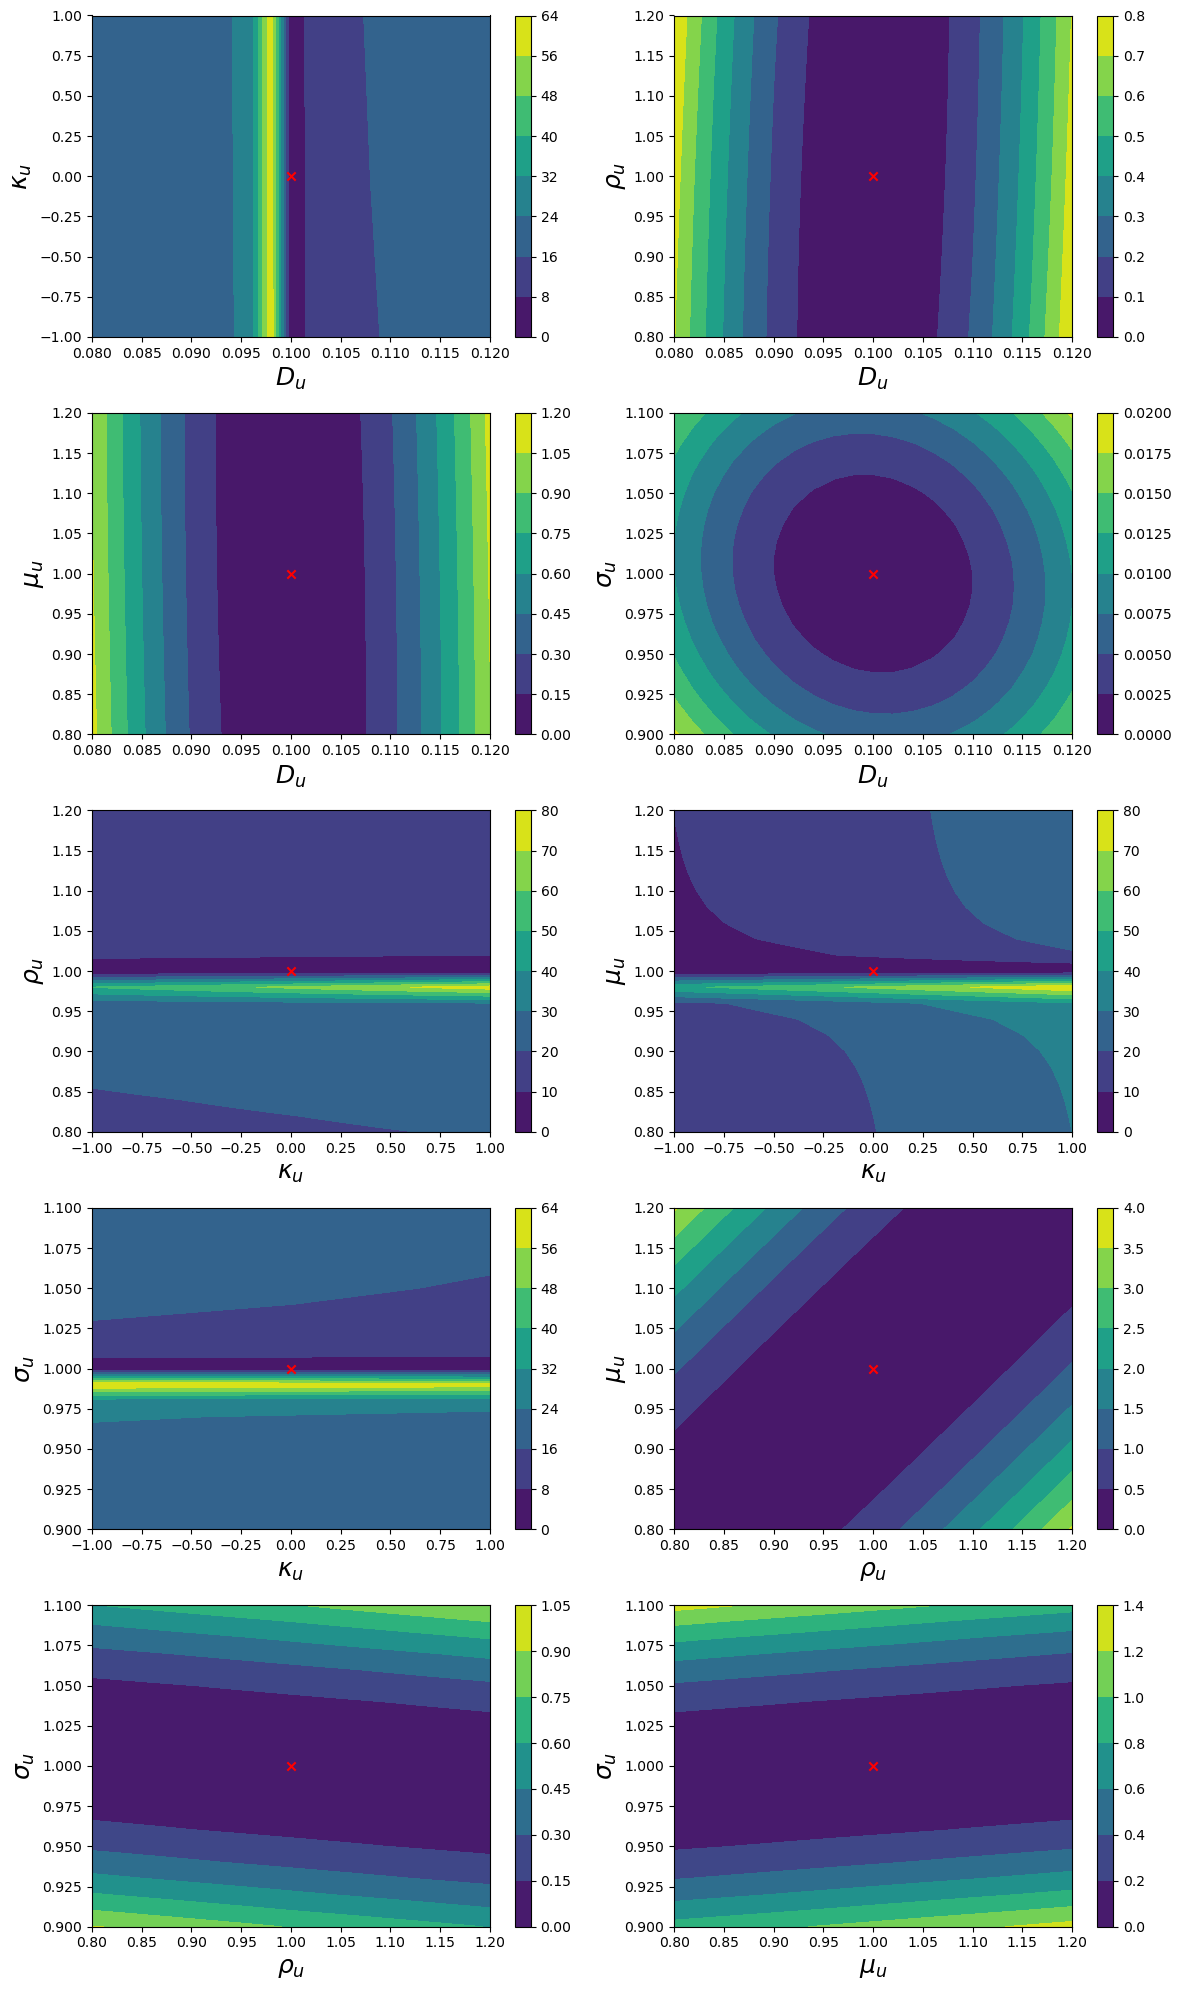

In [442]:
_ = plt.figure(figsize=(12,20))
for i, (loss_val, (param1, arr1, param2, arr2, _)) in enumerate(zip(u_losses, u_curry_func_others_combinations)):    
    plt.subplot(5, 2, i+1)
    plt.contourf(arr1, arr2, loss_val)
    #plt.contourf(loss_val)
    plt.colorbar()        
    plt.scatter(u_params[param1], u_params[param2], c='r', marker='x')
    plt.xlabel(fr'${symbols[param1]}$', fontsize=18)
    plt.ylabel(fr'${symbols[param2]}$', fontsize=18)
    
plt.tight_layout()
plt.show()

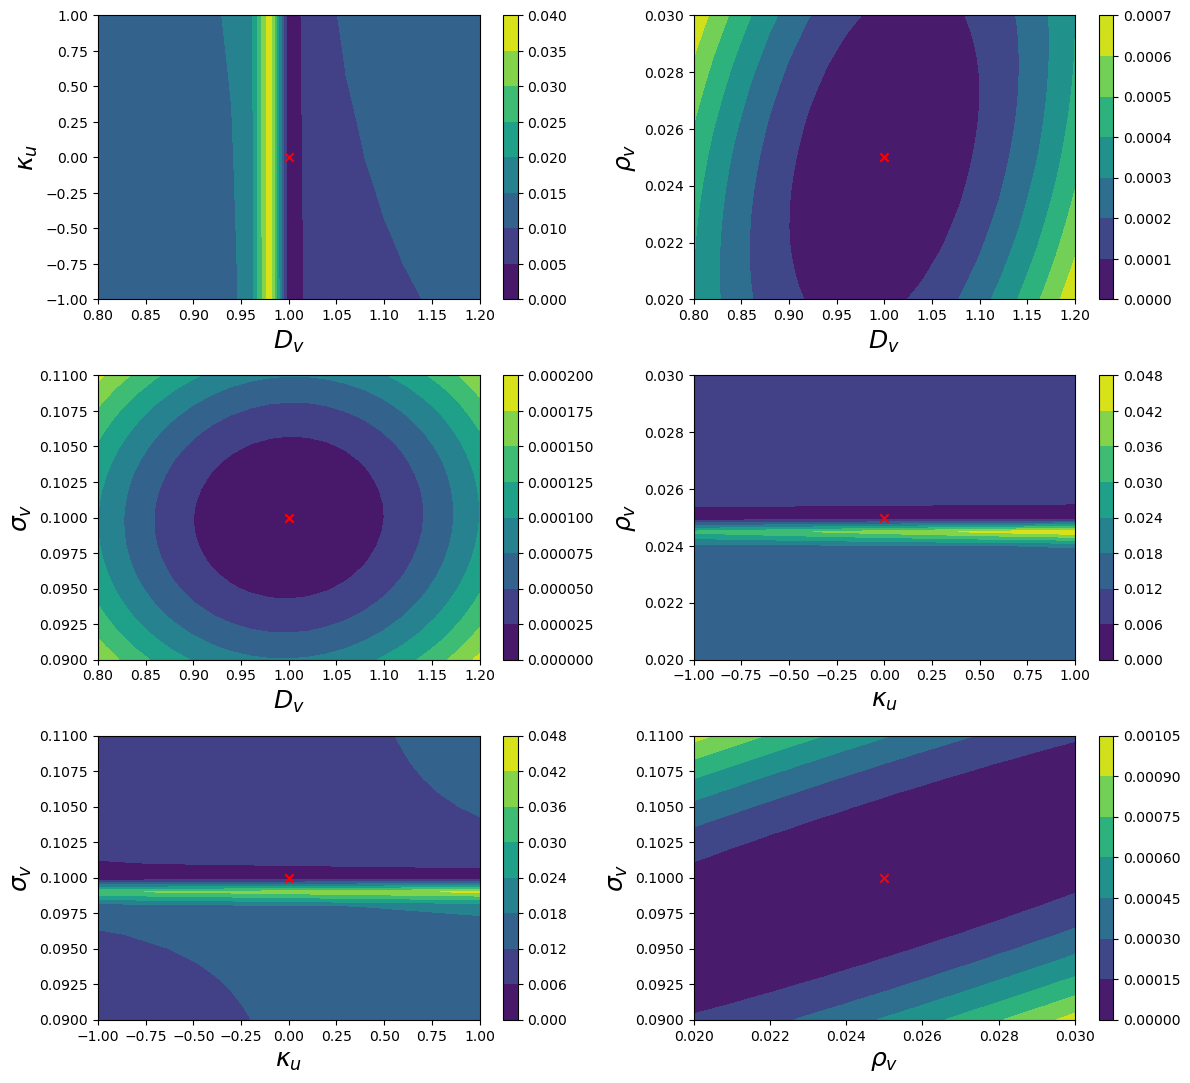

In [443]:
_ = plt.figure(figsize=(12,14))
for i, (loss_val, (param1, arr1, param2, arr2, _)) in enumerate(zip(v_losses, v_curry_func_others_combinations)):    
    plt.subplot(4, 2, i+1)
    plt.contourf(arr1, arr2, loss_val)
    #plt.contourf(loss_val)
    plt.colorbar()        
    plt.scatter(v_params[param1], v_params[param2], c='r', marker='x')
    plt.xlabel(fr'${symbols[param1]}$', fontsize=18)
    plt.ylabel(fr'${symbols[param2]}$', fontsize=18)
    
plt.tight_layout()
plt.show()

In [520]:
from jax import hessian, jacfwd, jacrev, jit
H = hessian(l2_loss, [i for i in range(len(params))])

In [489]:
H_value = jnp.array(H(params["D_u"], params["D_v"], params["kappa_u"],
            params["rho_u"], params["mu_u"], params["sigma_u"],
            params["rho_v"], params["sigma_v"]))

In [492]:
from scipy.linalg import eig
eig_vals, eig_vects = eig(H_value)

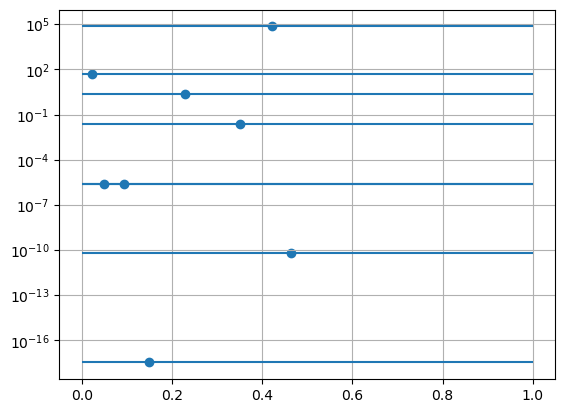

In [519]:
for v in eig_vals:
    plt.hlines(np.real(v), 0, 1)
    
plt.scatter(np.abs(np.random.normal(0, .2, eig_vals.shape)), np.real(eig_vals))
plt.yscale('log')
plt.grid()
plt.show()